Input size is (1, 28, 28)


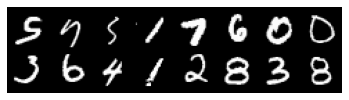

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
data = datasets.MNIST(root='./data',download=True, transform=transform)
img_shape = (data[1][0].size(0), data[1][0].size(1), data[1][0].size(2))
print(f'Input size is {img_shape}')

# Prepare dataloader for training
batch_size = 256
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True).cpu(),(1,2,0)))

In [2]:
###########################
### Vanilla GAN Training
###########################

from GAN_pytorch import Generator, Discriminator, Train

dim_latent = 100
lr = 0.001
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Initialize generator and discriminator
G = Generator(img_shape=img_shape, dim_latent=dim_latent, g_dims=[128,256,512,1024]).to(device)
D = Discriminator(img_shape=img_shape, d_dims=[512, 256]).to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

Train(epoch=50, dataloader=dataloader, cuda=cuda, G=G, D=D, 
      optimizer_G=optimizer_G, optimizer_D=optimizer_D)

# Save trained model if needed
# torch.save(G, "./vanilla_G.pt")
# torch.save(D, "./vanilla_D.pt")

# Load trained model if needed
# G = torch.load("./vanilla_G.pt")
# D = torch.load("./vanilla_D.pt")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 / D loss: 1.4559 / G loss: 1.1154
Epoch 10 / D loss: 1.3131 / G loss: 1.2599
Epoch 15 / D loss: 1.2397 / G loss: 0.7772
Epoch 20 / D loss: 1.2325 / G loss: 1.3214
Epoch 25 / D loss: 1.3033 / G loss: 1.0872
Epoch 30 / D loss: 1.3511 / G loss: 1.2327
Epoch 35 / D loss: 1.3975 / G loss: 0.5880
Epoch 40 / D loss: 1.2837 / G loss: 1.2239
Epoch 45 / D loss: 1.2847 / G loss: 0.9144
Epoch 50 / D loss: 1.2568 / G loss: 1.0762


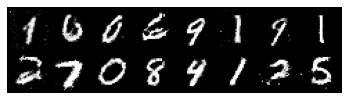

In [3]:
#################################
## Examples of Generated Images
#################################

G.eval()
z = torch.rand(16, dim_latent).to(device)
fake = G(z).detach().cpu()
plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:
#########################
###   CGAN Training
#########################

from CGAN_pytorch import Generator, Discriminator, Train

dim_latent = 100
num_class = 10
lr = 0.001
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Initialize generator and discriminator
G = Generator(img_shape=img_shape, num_class=num_class, 
              dim_latent=dim_latent, g_dims=[128,256,512,1024]).to(device)
D = Discriminator(img_shape=img_shape, num_class=num_class, d_dims=[512, 256]).to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

Train(epoch=50, dataloader=dataloader, cuda=cuda, G=G, D=D, 
      optimizer_G=optimizer_G, optimizer_D=optimizer_D)

# Save trained model if needed
# torch.save(G, "./CGAN_G.pt")
# torch.save(D, "./CGAN_D.pt")

# Load trained model if needed
# G = torch.load("./CGAN_G.pt")
# D = torch.load("./CGAN_D.pt")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 / D loss: 1.1680 / G loss: 1.0364
Epoch 10 / D loss: 1.0503 / G loss: 1.3044
Epoch 15 / D loss: 1.1489 / G loss: 1.0308
Epoch 20 / D loss: 1.3821 / G loss: 0.4599
Epoch 25 / D loss: 1.2993 / G loss: 1.1781
Epoch 30 / D loss: 1.2077 / G loss: 0.8547
Epoch 35 / D loss: 1.2033 / G loss: 1.0431
Epoch 40 / D loss: 1.1671 / G loss: 1.1390
Epoch 45 / D loss: 1.1881 / G loss: 0.9077
Epoch 50 / D loss: 1.1391 / G loss: 0.8541


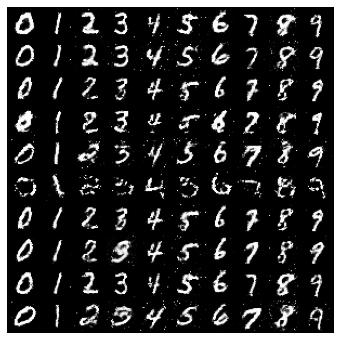

In [5]:
##################################
### Examples of Generated Images
##################################

num_sample = num_class**2
G.eval()
z = torch.zeros(num_sample, dim_latent).to(device)

# Fix noise z to generate conditioned result
for i in range(num_class):
    z[i*num_class] = torch.rand(1, dim_latent)
    for j in range(1, num_class):
        z[i*num_class + j] = z[i*num_class]
        
temp = torch.zeros(num_class, 1)
for i in range(num_class):
    temp[i, 0] = i

temp_y = torch.zeros(num_sample, 1)
for i in range(num_class):
    temp_y[i*num_class: (i+1)*num_class] = temp

labels = torch.zeros(num_sample, num_class).scatter_(1, temp_y.type(torch.LongTensor), 1).to(device)

fig = plt.figure(figsize=(6,6))
fake = G(z,labels).detach().cpu()
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()